<a href="https://colab.research.google.com/github/mayuneko-re/notebook/blob/master/Buckley_Leverett_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 水-油置換問題（Buckley-Leverettによる解法）

Version 2.01 (Sep. 2019)

油で満たされている多孔質媒体に対し，水を圧入し水攻する場合を考える．このとき，下記の条件のもと，解析的に解く手法をBuckley-Leverettの解法という．

- 一次元
- 非圧縮
- 非混和

この問題における水の質量保存式（無次元）は，以下のように表される．

$$
\frac{\partial S_w}{\partial t_D} + \frac{\partial f_w}{\partial x_D} = 0 
$$

ここで，$x_D$は無次元長さ，$t_D$は無次元時間であり，下記のとおり表される．

$$x_D = \frac{x}{L}$$

$$t_D = \int_0^t \frac{u}{\phi L} dt = \frac{qt}{V_p}$$

**参考文献:**

*   Buckley S and Leverett M, *Mechanism of Fluid Displacement in Sands*, 1941.
*   Welge H, *A Simplified Method for Computing Oil Recovery by Gas or Water Drive*, 1952.


**ライブラリのインポート**

In [0]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

## 流体の設定

今回必要なのは，油と水の二相．それぞれの粘度が必要になるので設定しておく．

In [0]:
oil_viscosity = 10 # cP
water_viscosity=0.5 # cP

## 相対浸透率モデル

ここでは，Coreyタイプの相対浸透率モデルを使用することにする．水の相対浸透率 $k_{rw}$ は下記のとおりモデル化される．

$$
k_{rw} = k_{rw}^0 \left( \frac{S_w - S_{wc}}{1 - S_{wc} - S_{or}} \right) ^ {n_w} 
$$

ここで，$k_{rw}^0$ はエンドポイントの水相対浸透率，$S_{wc}$ は connate water saturation，$S_{or}$ は残留油飽和率，$n_w$ は.形状パラメータである．
同様に，油の相対浸透率 $k_{ro}$ は以下のとおりモデル化される．

$$
k_{ro} = k_{ro}^0 \left( \frac{S_o - S_{or}}{1 - S_{wc} - S_{or}} \right) ^ {n_o}
$$

ここで， $k_{ro}^0$ はエンドポイント油相対浸透率，$n_o$ は形状パラメータである．

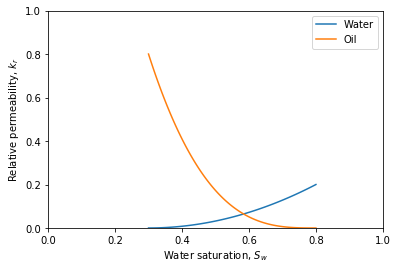

In [3]:
Swc = 0.3 # Vol/Vol, Connate water saturation
Sor = 0.2 # Vol/Vol, Residual oil saturation

# Saturation
Sw = np.linspace(start=Swc, stop=1-Sor, num = 100) # Water
So = 1- Sw # Oil

# Normalized saturation
Swn = np.linspace(start=0, stop=1, num = 100) # Water
Son = 1- Swn # Oil

# Relative permeability
def relperm(Sn, kr0, n):
    kr = kr0 * Sn ** n
    return kr

krw = relperm(Sn=Swn, kr0=0.2, n=2) # Water
kro = relperm(Sn=Son, kr0=0.8, n=3) # Oil

# Plotting
plt.plot(Sw, krw, label='Water')
plt.plot(Sw, kro, label='Oil')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Relative permeability, $k_r$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## フラクショナルフロー

**重力と毛細管圧力の影響が無視できるとき**，水と油のフラクショナルフローは下記のとおりとなる．

$$
f_w = \frac{\lambda_w}{\lambda_t} 
$$

$$
f_o = \frac{\lambda_o}{\lambda_t} 
$$

ここで，$\lambda_w$，$\lambda_o$，$\lambda_t$ はそれぞれ水，油，合計のモビリティを示し，下記のように計算される．

$$
\lambda_w = \frac{k \ k_{rw}}{\mu_w}
$$

$$
\lambda_o = \frac{k \ k_{ro}}{\mu_o}
$$

$$
\lambda_t = \lambda_w + \lambda_o
$$

従って，$f_w$は下記のとおり表される．

$$
f_w = \frac{\lambda_w}{\lambda_t} 
= \frac{1}{1+ \frac{k_{ro}}{\mu_o}   / \frac{k_{rw}}{\mu_w} }
$$

相対浸透率は飽和率のみの関数であるため，粘度が一定だとすると，フラクショナルフロー関数も飽和率のみの関数となる．

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
No handles with labels found to put in legend.


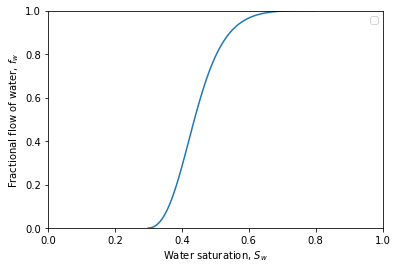

In [4]:
# Fractional flow of water
fw = 1 / (1 + (kro/oil_viscosity) / (krw/water_viscosity))

plt.plot(Sw, fw)
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Fractional flow of water, $f_w$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## Bucklery-Leverett theory

Buckley and Leverett (1941) は水の質量保存式から以下の関係式を導いた．

$$\frac{df_w}{dS_w} = \left. \frac{dx_D}{dt_D} \right|_{S_w} = v_D$$

導出は，Buckley and Leverett (1941) 等を参照して欲しい．この式は，**ある飽和率$S_w$は一定の速度$v_D$で進む**ということである．



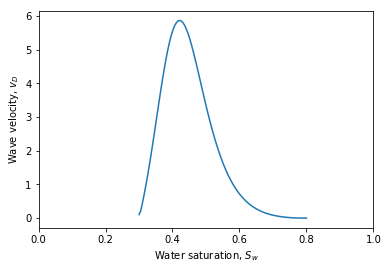

In [5]:
# Derivative of fractional flow of water
vD = np.gradient(fw, Sw)

# Plot
plt.plot(Sw, vD)
# plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Wave velocity, $v_D$')
plt.xlim(0, 1)
# plt.ylim(0,)
plt.show()

さて，ある$t_D$のときの飽和率分布を考えてみる．ある飽和率$S_w$のフロントは，一定の速度$v_D(S_w)$で進むから，


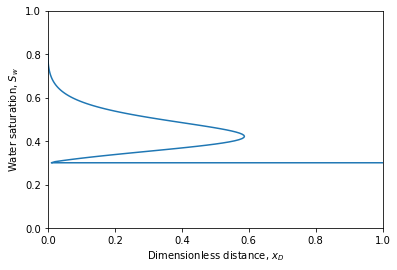

In [6]:
tD = 0.1 # PV
xD = vD * tD

plt.plot([1,*xD], [Swc,*Sw])
plt.xlabel('Dimensionless distance, $x_D$')
plt.ylabel('Water saturation, $S_w$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

これは物理現象に反している．飽和率の高いフロントが，飽和率の低いフロントを追い越しており，実際には生じ得ない．このとき，実際には，ショックフロントが形成され，ピストン状の置換が進行する．

### ショックフロント

ショックフロントの位置を決めるために，物理的な制約を課して解く．

*   **Velocity consraint:** Wave velocities in the two phase region must decrease monotonically for zones in which compositions vary continuously as the solution composition path is traced from down stream compositions to upstream compositions.
*   **Entropy condition:** Wave velocities on the upstream side of the shock must be greater than (or equal to) the shock velocity and wave velocities on the down stream side must be less than (or equal to) the shock velocity.

この制約のもと，フラクショナルフロー関数上で，初期条件からの接線として，ショックフロントは幾何的に決定される（Welge (1952)）．



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.



Dimensionless Shock Front velocity: 3.959
Shock Front water saturation: 0.487


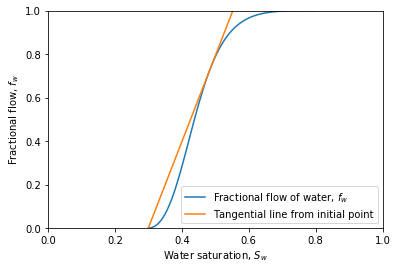

In [7]:
slope_fw = (fw - 0) / (Sw - Swc)  # Warning: slope_fw[0] = nan

vD_sf = np.nanmax(slope_fw) # Shock Front velocity
Sw_sf = Sw[np.nanargmax(slope_fw)] # Shock Front water saturation

print()
print('Dimensionless Shock Front velocity: {0:.3f}'.format(vD_sf))
print('Shock Front water saturation: {0:.3f}'.format(Sw_sf))

# Dimensionless velocity with Shock Front
vD[Sw<Sw_sf] = vD_sf

# Plot
plt.plot(Sw, fw, label='Fractional flow of water, $f_w$')
plt.plot(Sw, vD_sf*(Sw - Swc) , label='Tangential line from initial point')
plt.legend()
plt.xlabel('Water saturation, $S_w$')
plt.ylabel('Fractional flow, $f_w$')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## 飽和率分布


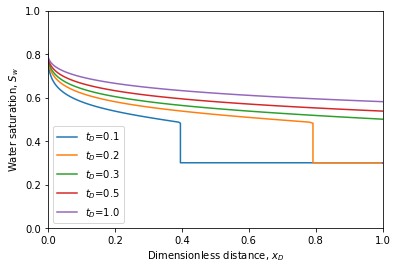

In [8]:
for tD in [0.1, 0.2, 0.3, 0.5, 1.0]:
    xD = vD * tD
    plt.plot([1, *xD], [Swc, *Sw], label='$t_D$='+str(tD))

plt.xlabel('Dimensionless distance, $x_D$')
plt.ylabel('Water saturation, $S_w$')
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

## プロット

In [0]:
# Dimensionless time for plotting
tD = np.linspace(start=0, stop=2, num = 100)

ブレークスルーする時間（Dimensionless time at breakthrough） $t_{D, BT} $ [PV] は，ショックフロントが流出側に到達する時間であるので，

$$ t_{D, BT} = \frac{1}{v_{D, sf}}$$

In [10]:
tD_BT = 1/vD_sf
print('Dimensionless time at Breakthrough: {0:.3f} PV'.format(tD_BT))

Dimensionless time at Breakthrough: 0.253 PV


### 平均水飽和率

多孔質媒体全体の平均水飽和率 $\bar{S_w}$ は下記のとおり表される．

$$
\bar{S_w} =
        \begin{cases}
            S_{wc} + t_D \quad \quad  \quad t_D \le t_{D, BT}  \\
            S_{w, out} - \frac{f_{w, out} - 1}{f'_{w, out} }  \quad otherwise \\
        \end{cases}
$$

ここで，$S_{w, out}$ は流出面での水飽和率，$f_{w, out}$ は流出面での水のフラクショナルフロー， $f'_{w, out}$ はその微分値である．

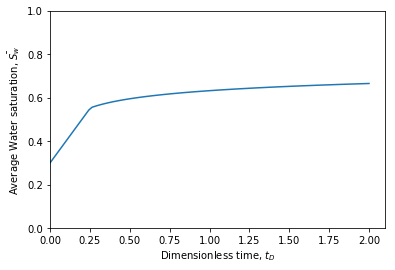

In [11]:
# Water saturation at outlet
f = interpolate.interp1d(vD, Sw, kind='linear')
Sw_out =  np.array([Swc if tDi < tD_BT else  f(1/tDi) for tDi in tD])

# Fractional flow of water at outlet
f = interpolate.interp1d(vD, fw, kind='linear')
fw_out =  np.array([0 if tDi < tD_BT else  f(1/tDi) for tDi in tD])

# Average water saturation at whole region
Sw_ave = np.array([Swc + tD[i] if tD[i] < tD_BT else Sw_out[i] - (fw_out[i] - 1) / (1/tD[i]) for i in range(len(tD))])

# Plot
plt.plot(tD, Sw_ave)
# plt.legend()
plt.xlabel('Dimensionless time, $t_D$')
plt.ylabel('Average Water saturation, $\\bar{S_w}$')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

### 油の回収量

油の回収量 $N$ [PV] は下記のように表される．

$$
N =
        \begin{cases}
            t_{D} \quad \quad & t_D \le t_{D, BT}  \\
            \bar{S_w} - S_{wc}  \quad & otherwise \\
        \end{cases}
$$

なお，ブレークスルー時は下記のとおり．

$$N_{BT} =  t_{D, BT} $$

Oil recovery volume at Breakthrough: 0.253 PV


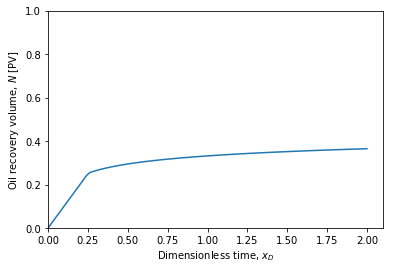

In [12]:
N = np.array([tD[i] if tD[i] < tD_BT else Sw_ave[i] - Swc for i in range(len(tD))])

N_BT = tD_BT
print('Oil recovery volume at Breakthrough: {0:.3f} PV'.format(N_BT))

# Plot
plt.plot(tD, N, )
# plt.legend()
plt.xlabel('Dimensionless time, $x_D$')
plt.ylabel('Oil recovery volume, $N$ [PV]')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

### 油回収率

油の回収率 $RF$ [HCPV] は下記のように表される．

$$
{RF} = \frac{N}{1-S_{wc}}
$$

ブレークスルー時は下記のとおり．

$$
{RF}_{BT} = \frac{N_{BT}}{1-S_{wc}}
$$

Oil recovery factor at Breakthrough: 0.361 HCPV


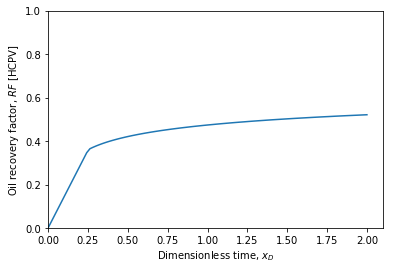

In [13]:
RF = N / (1 - Swc)

RF_BT = N_BT / (1 - Swc) 
print('Oil recovery factor at Breakthrough: {0:.3f} HCPV'.format(RF_BT))

# Plot
plt.plot(tD, RF)
# plt.legend()
plt.xlabel('Dimensionless time, $x_D$')
plt.ylabel('Oil recovery factor, $RF$ [HCPV]')
plt.xlim(0,)
plt.ylim(0, 1)
plt.show()

*End of notebook...*